Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", remove any ```raise NotImplementedError()``` and enter your student ID below:

In [1]:
STUDENT_ID = "200774408"

---

# Coursework 7

This is the solution notebook for coursework 7 of module MTH793P 2020/2021 at Queen Mary University of London.

Author: [Martin Benning](mailto:m.benning@qmul.ac.uk)

Date: 12.03.2021

Last modified: 12.03.2021

First we load the necessary libraries for this coursework

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import scipy.io

In [3]:
from scipy.linalg import svd

Next, we update the sizes and fontsizes of the figures in this notebook.

In [4]:
plt.rcParams['figure.figsize'] = [9, 9]
plt.rcParams.update({'font.size': 16})

Now we load the Yale faces B mat-file *yale-b-faces.mat* with the help of scipy and store the data into the matrix *all_faces*. The dataset contains 2410 images of size $192 \times 168$ of 38 different people. The number of images per person is stored in the vector *number_of_faces_per_person*.

In [5]:
mat_file_import = scipy.io.loadmat('yale-b-faces.mat')
all_faces = mat_file_import['faces']
number_of_faces_per_person = mat_file_import['nfaces'].reshape(-1)

Before we start processing the data, we write a couple of helper functions for the following exercise. The function *standardise* and *de_standardise* will allow column-wise standardisation of a matrix _matrix_ and are already known from Coursework 6. Write a function soft_shrinkage that performs the component-wise soft shrinkage
$$ \text{soft}_{\alpha}(f) = \text{sign}(f) \max( |f | - \alpha, 0) , $$
of an array $f$, where $\alpha$ is denoted by *regularisation_parameter* and the input $f$ by *input_vector*. Write another function *nuclear_norm_proximal_mapping* that computes the solution of 
$$ \arg\min_{M \in \mathbb{R}^{n \times s}} \left\{ \frac12 \| M - X \|^2_{\text{Fro}} + \alpha \| M \|_\ast \right\} , $$
which is nothing but the soft-thresholding of the singular values (see lecture notes for more details). Here $\alpha$ is also denoted by *regularisation_parameter* and the input $X$ is known as _matrix_.

In [6]:
def standardise(matrix):
    means = np.mean(matrix.T, axis=0)
    output = matrix.T - means
    stds = np.std(output, axis=0)
    output /= stds
    return output.T, means, stds

def de_standardise(matrix, means, stds):
    output = matrix.T * stds
    output += means
    return output.T

In [7]:
def soft_shrinkage(input_array, regularisation_parameter=1):
    return np.sign(input_array) * np.maximum(np.abs(input_array) - regularisation_parameter, 0)

def nuclear_norm_proximal_mapping(matrix, regularisation_parameter=1):
    u, s, vh = svd(matrix, full_matrices=False)
    shat = np.maximum(s - regularisation_parameter, 0)
    return (u * shat[..., None, :]) @ vh

Test your nuclear norm proximal maps with the following test cells (one visible, one hidden) that are worth **2 marks**.

In [8]:
from numpy.testing import assert_array_almost_equal, assert_array_equal, assert_array_less
test_matrix = np.array([[5, -4, 1], [-5, 5, 0], [0, 0, 5], [-1, 0, 4]])
assert_array_almost_equal(nuclear_norm_proximal_mapping(test_matrix, regularisation_parameter=6.47256933), \
                          np.array([[ 1.54724848, -1.38976211, 0.14352547], [-1.69073118, 1.51864046, \
                                    -0.15683517], [ 0.08262244, -0.07421273, 0.0076642], [-0.11204109, \
                                    0.10063701, -0.01039313]]))

Next, we store all standardised face images of the first person in a data matrix *matrix* and the corresponding means and standard deviations in *means* and *stds*, respectively.

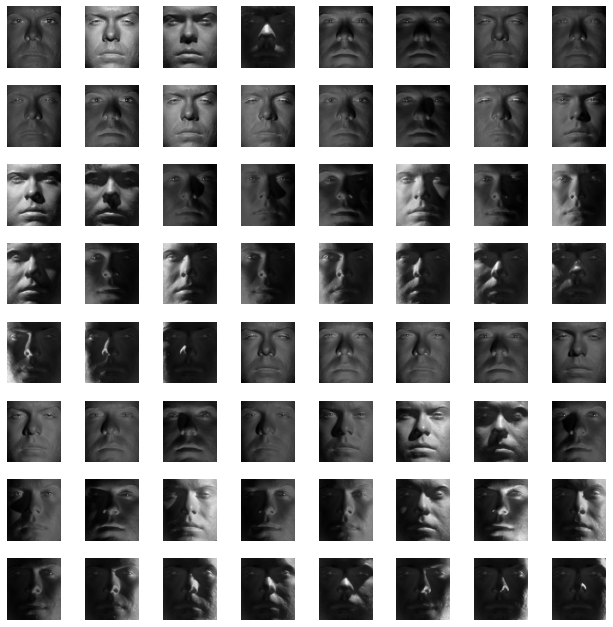

In [9]:
# YOUR CODE HERE
matrix, means, stds = standardise(all_faces[:,:number_of_faces_per_person[0]].astype('float64'))
for counter in range(number_of_faces_per_person[0]):
    plt.subplot(8, 8, counter + 1)
    plt.imshow(matrix[:, counter].reshape((168, 192)).T, cmap='gray')
    plt.axis('off') 
plt.tight_layout();

We implement a function **robust_pca** based on the linearised Bregman iteration and accelerated linearised Bregman iteration as introduced in the lecture notes, for fixed step-size $\tau = 1/2$. The function takes the arguments as specified in the function header. Here *matrix* is the matrix $X$ we seek to decompose into a low-rank matrix $L$ and a sparse matrix $S$. The argument *matrix* also acts as initilisation $X^0$ for the corresponding update; the matrices $L^0$ and $S^0$ should be initialised as zero matrices of correct size. The argument *regularisation parameter* is an array with two elements. The first component of *regularisation parameter* corresponds to the balancing parameter in front of the nuclear norm ($\gamma \alpha$ in the lecture notes), while the second parameter corresponds to the balancing parameter in front of the one-norm ($\gamma$ in the lecture notes). If *regularisation_parameters* is set to **None**, make sure to initialise them as $\left(\begin{matrix} 10 \sqrt{\max(m, n)} & 10\end{matrix} \right)^\top$, where $m$ denotes the no. of rows of *matrix* and $n$ the no. of columns. The parameter *maximum_no_of_iterations* specifies the maximum number of iterations before the algorithm terminates, while *tolerance* is a quantity that forces the iteration to stop when

$$ \frac12 \| L^k + S^k - X \|^2_{\text{Fro}} \leq \text{tolerance} $$

is achieved. If *tolerance* is set to **None**, make sure to initialise it as $\text{tolerance} = \frac{10^{-8}}{2} \| X \|^2_{\text{Fro}}$, where $X$ is the mathematical notation of *matrix*. The parameter *acceleration* indicates if acceleration is enabled or disabled. If it is enabled, the adaptive parameter $\beta_k$ should be chosen as

$$ \beta_0 = 0 \qquad \text{and} \qquad \beta_k = \frac{k - 1}{k + 3} \, , $$

for $k = 1, 2, \ldots$. The function should return the matrices $L$ (variable name *low_rank_matrix*) and $S$ (variable name *sparse_matrix*), as well as a list *sensitivities* of values $\frac12 \| L^k + S^k - X \|^2_{\text{Fro}}$ for all iterates $k = 0, 1, \ldots, K$, where $K$ denotes the final iterate.

In [10]:
def adaptive(k):
    return (k - 1) / (k + 3) * (k >= 1)

def robust_pca(matrix, regularisation_parameters=None, maximum_no_of_iterations=1500, tolerance=None, \
               acceleration=False):
    """
    
    Returns
    -------
    Lk: low-rank matrix
    Sk: sparse matrix
    sensitivities: list of sensitivities
    """
    m, n = matrix.shape
    τ = 1/2
    if regularisation_parameters is None:
        regularisation_parameters = np.array([[10 * np.sqrt(np.maximum(m, n)), 10]]).T
    if tolerance is None:
        tolerance = np.linalg.norm(matrix, "fro") ** 2 * 10 ** (-8) / 2
    
    # balancing parameters: nuclear norm and one-norm
    γα, γ = regularisation_parameters
    Yk = matrix.copy()
    Xk = matrix.copy()
    sensitivities = []
    for k in range(1, maximum_no_of_iterations+2):
        Lk = nuclear_norm_proximal_mapping(τ * Yk, γα)
        Sk = soft_shrinkage(τ * Yk, γ)
        update_term = Lk + Sk - matrix
        Xk_next = Yk - update_term
        if acceleration:
            Yk = (1 + adaptive(k)) * Xk_next - adaptive(k) * Xk
            Xk = Xk_next
        else:
            Yk = Xk_next
            
        sensitivity = np.linalg.norm(update_term, "fro") ** 2 / 2
        sensitivities.append(sensitivity)
        
        if k % 5 == 0:
            end = "\n" if k % 50 == 0 else "\r"
            print(f"@{k=:04} | {sensitivity=:0.7f}", end=end)
        if sensitivity <= tolerance:
            break
    
    return Lk, Sk, sensitivities

Test your code with the following cells (one visible, one hidden). Each cell is worth one mark, or **two marks** in total.

In [11]:
L_test, S_test, sensitivities_test = robust_pca(test_matrix)
assert_array_almost_equal(L_test, np.array([[2.49075607, -2.40229354, 1.00022123], [-2.42827975, 2.29324288, \
                                            -4.88329427e-04], [-6.95002261e-04, -4.85666968e-02, 9.83228777e-01], \
                                            [-5.24058894e-02, 6.91996128e-04, 9.74759912e-01]]))
assert_array_almost_equal(S_test, np.array([[2.50922883, -1.59769614, 0], [-2.57170666, 2.70674203, 0], \
                                            [0, 0.04850046, 4.01677881], [-0.94753219, 0, 3.02525679]]))
assert_array_less(sensitivities_test[-1], 10**(-8) * (np.linalg.norm(test_matrix, 'fro') ** 2)/2)

@k=0050 | sensitivity=0.0462163
@k=0100 | sensitivity=0.0131342
@k=0150 | sensitivity=0.0027779
@k=0200 | sensitivity=0.0000683
@k=0250 | sensitivity=0.0000009


Compute a robust PCA decomposition of *matrix* without acceleration and store your low-rank matrix in a variable named *L* and your sparse matrix in a variable *S*, and the sensitivities in a variable named *sensitivities*. The execution time of your code should not exceed 350 seconds.

In [12]:
import time
start_time = time.time()
L, S, sensitivities = robust_pca(matrix, maximum_no_of_iterations=600)
end_time = time.time()
print("The computation took {:.2f} seconds.".format(end_time - start_time))

@k=0050 | sensitivity=9710.611516573
@k=0100 | sensitivity=3183.8387766
@k=0150 | sensitivity=1418.0540209
@k=0200 | sensitivity=810.59815454
@k=0250 | sensitivity=534.6478929
@k=0300 | sensitivity=356.4928294
@k=0350 | sensitivity=259.9713093
@k=0400 | sensitivity=196.8358107
@k=0450 | sensitivity=152.9184325
@k=0500 | sensitivity=121.6766885
@k=0550 | sensitivity=96.34247442
@k=0600 | sensitivity=80.4315205
The computation took 69.23 seconds.


The following cell tests if your code was executed within the time limit. This test is awarded **1 mark**.

Visualise the first column of all matrices *matrix*, *M* := *L* + *S*, *L* and *S* as gray-scale images.  

The rank of L is 23, and the difference between X and L + S is 80.15596656744732.


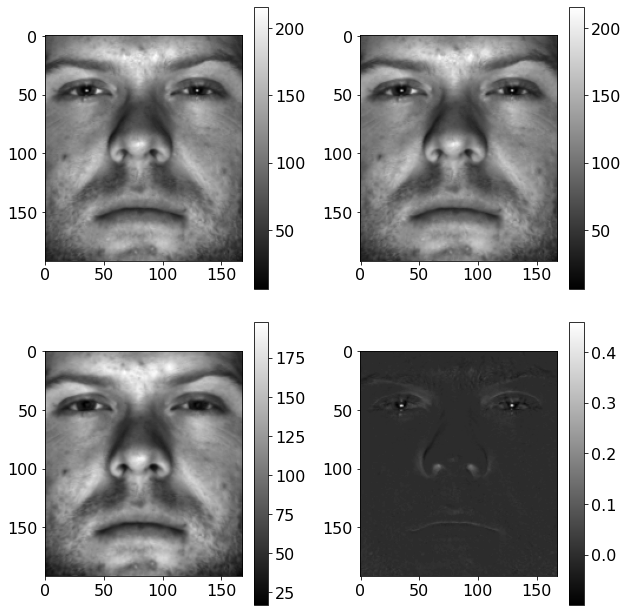

In [13]:
M = L + S
matrix_dst = de_standardise(matrix, means, stds)
M_dst = de_standardise(M, means, stds)
L_dst = de_standardise(L, means, stds)
S_scaled = S - np.min(S)
S_scaled = S / np.max(S_scaled)
index = 4
figure, (axis1, axis2) = plt.subplots(2, 2)
image1 = axis1[0].imshow(matrix_dst[:, index].reshape((168, 192)).T, cmap='gray')
image2 = axis1[1].imshow(M_dst[:, index].reshape((168, 192)).T, cmap='gray')
image3 = axis2[0].imshow(L_dst[:, index].reshape((168, 192)).T, cmap='gray')
image4 = axis2[1].imshow(S_scaled[:, index].reshape((168, 192)).T, cmap='gray')
figure.colorbar(image1, ax=axis1[0])
figure.colorbar(image2, ax=axis1[1])
figure.colorbar(image3, ax=axis2[0])
figure.colorbar(image4, ax=axis2[1])
plt.tight_layout()
print("The rank of L is {r}, and the difference between X and L + S is {d}.".format(r = np.linalg.matrix_rank( \
        L), d = 1/2*np.linalg.norm(matrix - M, 'fro') ** 2))

Compute a robust PCA decomposition of *matrix* **with** acceleration and store your low-rank matrix in a variable named *L_accelerated* and your sparse matrix in a variable *S_accelerated*, and the sensitivities in a variable named *sensitivities_accelerated*.

In [14]:
%%time
L_accelerated, S_accelerated, sensitivities_accelerated = robust_pca(matrix, acceleration=True)

@k=0050 | sensitivity=1653.100528938
@k=0100 | sensitivity=165.96135765
@k=0150 | sensitivity=28.30268795
@k=0200 | sensitivity=6.20193474
@k=0250 | sensitivity=1.7680183
@k=0300 | sensitivity=0.5664542
@k=0350 | sensitivity=0.2327250
@k=0400 | sensitivity=0.1014265
@k=0450 | sensitivity=0.0461344
@k=0500 | sensitivity=0.0241225
@k=0550 | sensitivity=0.0129391
CPU times: user 4min 41s, sys: 9.88 s, total: 4min 51s
Wall time: 1min 13s


Visualise your results in identical fashion as before.

The rank of L is 29, and the difference between X and L + S is 0.010197867192591891.


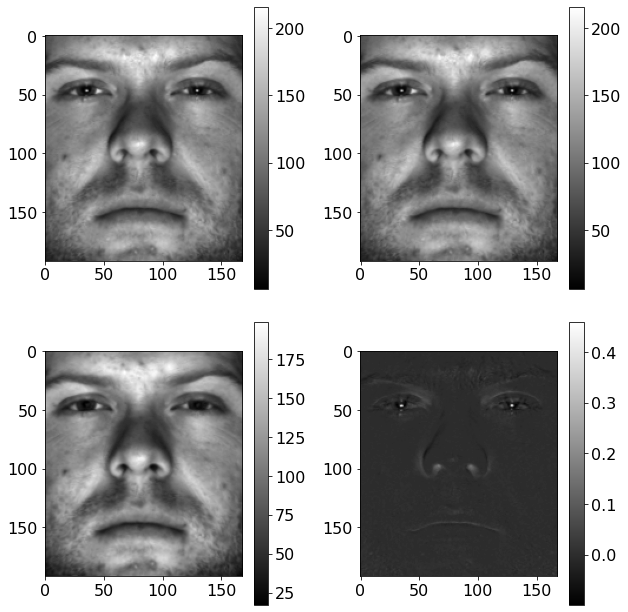

In [15]:
M_accelerated = L_accelerated + S_accelerated
X_dst = de_standardise(matrix_dst, means, stds)
M_accelerated_dst = de_standardise(M_accelerated, means, stds)
L_accelerated_dst = de_standardise(L_accelerated, means, stds)
S_accelerated_scaled = S_accelerated - np.min(S_accelerated)
S_accelerated_scaled = S_accelerated / np.max(S_accelerated_scaled)
index = 4
figure, (axis1, axis2) = plt.subplots(2, 2)
image1 = axis1[0].imshow(matrix_dst[:, index].reshape((168, 192)).T, cmap='gray')
image2 = axis1[1].imshow(M_accelerated_dst[:, index].reshape((168, 192)).T, cmap='gray')
image3 = axis2[0].imshow(L_accelerated_dst[:, index].reshape((168, 192)).T, cmap='gray')
image4 = axis2[1].imshow(S_accelerated_scaled[:, index].reshape((168, 192)).T, cmap='gray')
figure.colorbar(image1, ax=axis1[0])
figure.colorbar(image2, ax=axis1[1])
figure.colorbar(image3, ax=axis2[0])
figure.colorbar(image4, ax=axis2[1])
plt.tight_layout()
print("The rank of L is {r}, and the difference between X and L + S is {d}.".format(r = np.linalg.matrix_rank( \
        L_accelerated), d = 1/2*np.linalg.norm(matrix - M_accelerated, 'fro') ** 2))

Next, we compare the robust PCA low-rank component to the low-rank approximation with standard PCA. We use *svd_thresholding* from Coursework 6 to compute this low-rank approximation and store it in a variable *pca_low_rank*. Make sure that the rank is identical of that of *L_accelerated*.

In [16]:
def svd_thresholding(input_matrix, rank):
    s, n = input_matrix.shape
    U, singular_values, V_transpose = scipy.linalg.svd(input_matrix, full_matrices=False)
    σk = singular_values.copy()
    σk[rank:] = 0
    
    Xk = np.einsum("ik,k,kj->ij", U, σk, V_transpose, optimize=True)
    return Xk

rank = np.linalg.matrix_rank(L_accelerated)
pca_low_rank_dst = svd_thresholding(matrix, rank)

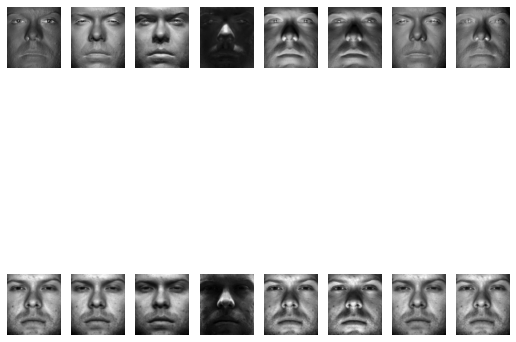

In [17]:
for counter in range(8):    
    plt.subplot(2, 8, counter + 1)
    plt.imshow(pca_low_rank_dst[:, counter].reshape((168, 192)).T, cmap='gray')
    plt.axis('off') 
    plt.subplot(2, 8, counter + 9)
    plt.imshow(L_accelerated_dst[:, counter].reshape((168, 192)).T, cmap='gray')
    plt.axis('off') 
plt.tight_layout;

Visualise and compare the convergence behaviour with the following cell.

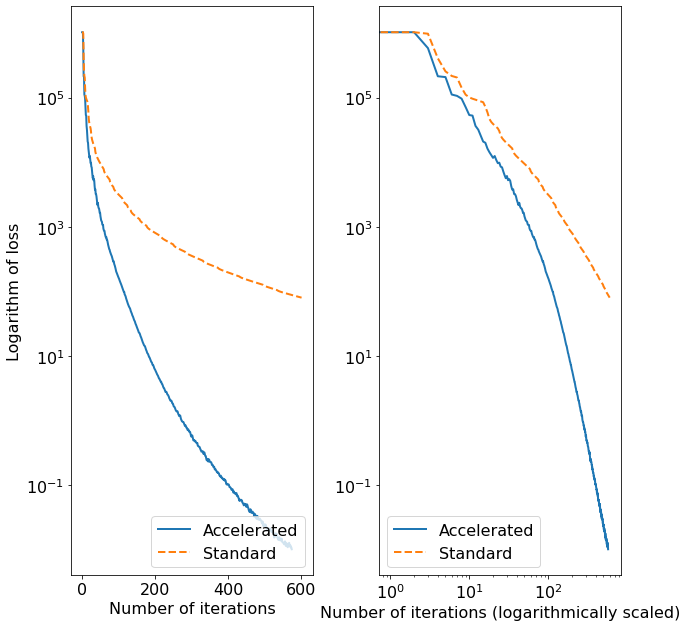

In [18]:
figure, axis = plt.subplots(1, 2)
line1 = axis[0].plot(np.linspace(0, len(sensitivities_accelerated), len(sensitivities_accelerated)), \
                        sensitivities_accelerated, linewidth=2, label='Accelerated')
line2 = axis[0].plot(np.linspace(0, len(sensitivities), len(sensitivities)), sensitivities, '--', \
                        linewidth=2, label='Standard')
axis[0].set_yscale('log')
axis[0].set_xlabel('Number of iterations')
axis[0].set_ylabel('Logarithm of loss')
axis[0].legend(loc='lower right')
line1 = axis[1].plot(np.linspace(0, len(sensitivities_accelerated), len(sensitivities_accelerated)), \
                        sensitivities_accelerated, linewidth=2, label='Accelerated')
line2 = axis[1].plot(np.linspace(0, len(sensitivities), len(sensitivities)), sensitivities, '--', \
                        linewidth=2, label='Standard')
axis[1].set_yscale('log')
axis[1].set_xscale('log')
axis[1].set_xlabel('Number of iterations (logarithmically scaled)')
axis[1].legend(loc='lower left')
plt.tight_layout()
plt.savefig('robust-PCA-convergence.pdf')
plt.show();

This concludes this week's coursework.